# Import Libraries

In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt
import warnings
import string
warnings.filterwarnings("ignore", category=FutureWarning)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import The Dataset

The data processed contains the the training data, validation data, and test data (with unmasked and masked label) that has been preprocessed. However, later on, we will further preprocess the code to increase the accuracy.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv("drive/MyDrive/sentiment-prosa/train_preprocess.tsv", sep='\t', header=None)
df_valid = pd.read_csv("drive/MyDrive/sentiment-prosa/valid_preprocess.tsv", sep='\t', header=None)
df_test_unmasked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess.tsv", sep='\t', header=None)
df_test_masked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess_masked_label.tsv", sep='\t', header=None)

Open the vocabulary document

In [4]:
with open('drive/MyDrive/sentiment-prosa/vocab_uncased.txt', 'r') as f:
    vocab = f.read().splitlines()

In [5]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


# Pre-processing

## Remove punctuation and numbers

In [6]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [7]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(remove_punctuation)
df_test_masked['text'] = df_test_masked['text'].apply(remove_punctuation)

vocab_filtered = []

for word in vocab:
  word_filtered = remove_punctuation(word)
  vocab_filtered.append(word_filtered)



## Stop words removal and tokenization

In [8]:
# Set stopwords
stop_words = set(stopwords.words('indonesian'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply tokenization to the train, validation, and test datasets
df_train['text'] = df_train['text'].apply(tokenize_text)
df_valid['text'] = df_valid['text'].apply(tokenize_text)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize_text)

In [9]:
df_train.head(10)

,text,emotion
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatera bandung nya ny...,positive
3,betapa bahagia nya unboxing paket barang nya b...,positive
4,duh mahasiswa sombong kasih kartu kuning belaj...,negative
5,makanan beragam harga makanan food stall kasir...,positive
6,pakai kartu kredit bca untung rugi,negative
7,unik bagus foto makanan enak pegawai ramah ber...,positive
8,keluarga menikmati pengalaman kuliner menyenan...,positive
9,bersyukur,positive


In [10]:
df_test_unmasked.head(10)

,text,emotion
0,kemarin gue makan dago gue makanan nya enak ha...,negative
1,kayak nya sih gue gila ya gue ngerti nya dibia...,negative
2,dipikir pikir dibanggakan jokowi nepatin janji...,negative
3,kalinya gua bank ngurusin pembuatan rekening n...,negative
4,gue disuruh latihan karate nya biar gue melawa...,negative
5,pelayanan hotel salak bogor sebagus gue membay...,negative
6,young lex mengirim berfaedah kayak gitu merusa...,negative
7,gue pesimis manusia ngurusin sampah hewan hewa...,negative
8,kecewa pengeditan biodata penumpang by sistem ...,negative
9,pemesanan tiket kunjung terima menelpon pelaya...,negative


# Exploratory Data Analysis

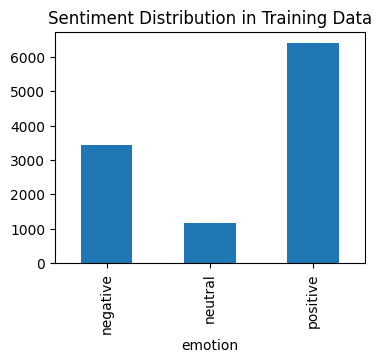

,text
emotion,
negative,3436
neutral,1148
positive,6416


In [11]:
fig = plt.figure(figsize=(4,3))
df_train.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Sentiment Distribution in Training Data")
plt.show()
df_train.groupby('emotion').text.count()

In [12]:
# Encoding emotions
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

# Experiment 1: Decision Tree

## Training

In [13]:
# Create a bag of words from the vocab_uncased.txt
cleaned_vocab = [string.strip() for string in vocab_filtered if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

# Extract training, validation, and test data into each array and transform using vocabulary
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

In [14]:
# Create Decision Tree model and train
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Validate data set
y_valid_pred = dt_model.predict(X_valid)

## Evaluate training model

In [15]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [16]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.776984126984127
Precision: 0.717878748250809
Recall: 0.7151655929805822
F1-Score: 0.7159599293843862
              precision    recall  f1-score   support

    negative       0.67      0.73      0.70       394
     neutral       0.61      0.58      0.60       131
    positive       0.87      0.84      0.85       735

    accuracy                           0.78      1260
   macro avg       0.72      0.72      0.72      1260
weighted avg       0.78      0.78      0.78      1260



In [17]:
# Predict x column using DT model
y_test_pred = dt_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.53
Test Precision: 0.528149060671389
Test Recall: 0.4875479912244618
Test F1-Score: 0.49755683510534593
Banyak data yang salah diprediksi: 235


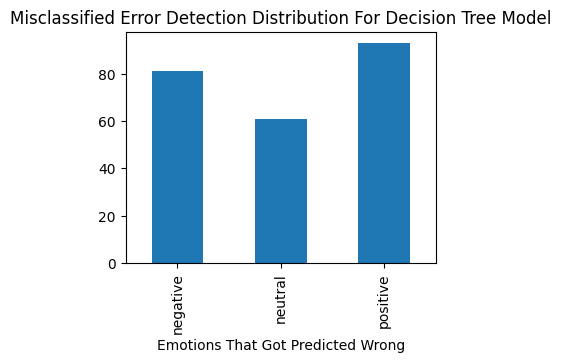

,text
emotion,
negative,81
neutral,61
positive,93


In [18]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Decision Tree Model")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 2: Hypertuning Parameters

In [19]:
# Use hypertuning to get optimal results
parameters = {
    'max_depth': [5, 10, 20, 50, 100, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 300, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [25]:
# Create Decision Tree model and train
dt_model = DecisionTreeClassifier(random_state=42, max_depth=300, min_samples_split=5, min_samples_leaf=2)
dt_model.fit(X_train, y_train)

# Validate data set
y_valid_pred = dt_model.predict(X_valid)

## Evaluate training model

In [26]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [27]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.7674603174603175
Precision: 0.7133370094593897
Recall: 0.697576937544499
F1-Score: 0.7009462984348946
              precision    recall  f1-score   support

    negative       0.63      0.77      0.69       394
     neutral       0.62      0.51      0.56       131
    positive       0.89      0.81      0.85       735

    accuracy                           0.77      1260
   macro avg       0.71      0.70      0.70      1260
weighted avg       0.78      0.77      0.77      1260



In [28]:
# Predict x column using DT model
y_test_pred = dt_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.582
Test Precision: 0.5623737729557089
Test Recall: 0.5151115224644637
Test F1-Score: 0.5151577677111567
Banyak data yang salah diprediksi: 209


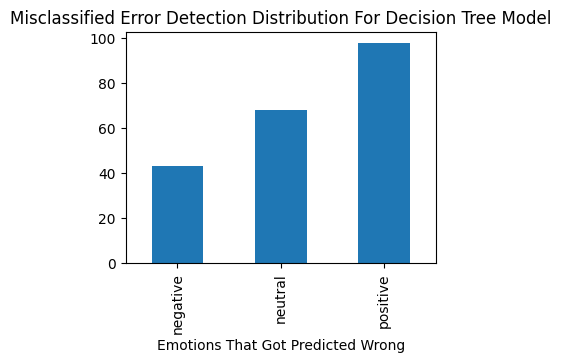

,text
emotion,
negative,43
neutral,68
positive,98


In [29]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Decision Tree Model")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()